### Preamble
- This notebook is overviews the provided API for using GPflow-based models
- Available models inherit from the following base class (shown in simplified form here):
```python
class PathwiseGPModel(GPModel):
    def __init__(self, *args, paths: AbstractSampler = None, **kwargs):
        super().__init__(*args, **kwargs)
        self._paths = paths
 
    @abstractmethod
    def generate_paths(self, *args, **kwargs) -> AbstractSampler:
        raise NotImplementedError

    def predict_f_samples(self, Xnew: TensorLike):
        return self.paths(Xnew, **kwargs)
```
- These classes act **identical** to their GPflow counterparts, save for `predict_f_samples`
- Below, we demonstrate some common usage patterns for the basic `<PathwiseGPR>` model class

In [6]:
import numpy as np
import tensorflow as tf

from gpflow.config import default_float as floatx
from gpflow.kernels import Matern52, Periodic, SquaredExponential
from gpflow_sampling.models import PathwiseGPR
import matplotlib.pyplot as plt
tf.random.set_seed(1)

### Generate toy data

In [7]:
kernel = Matern52()
freq = 200
lengthscale = 0.1
#kernel.period.assign((1 / freq) if freq != 0 else 1)
#kernel.base_kernel.lengthscales.assign(lengthscale)
noise2 = 1e-3  # measurement noise variance

xmin = 0.15  # range over which we observe
xmax = 0.50  # the behavior of a function $f$
X = tf.convert_to_tensor(np.linspace(xmin, xmax, 10)[:, None])
y = tf.convert_to_tensor(np.random.rand(10)[:, None], dtype=floatx())

### Create model and predict moments

In [8]:
model = PathwiseGPR(data=(X, y), kernel=kernel, noise_variance=noise2)
Xnew = np.linspace(0, 1, 2024)[:, None]

- The class's `generate_paths` method should return function draws (i.e. paths)
- If keyword argument `prior=None`, prior samples are constructed using `num_bases` Random Fourier Features (RFF)

In [9]:
paths = model.generate_paths(num_samples=2, num_bases=2024)  # returned paths are deterministic!
f_orig = paths(Xnew)
print(f"shape(f) = {f_orig.shape}")

<class 'gpflow_sampling.sampling.core.DenseSampler'> <gpflow_sampling.sampling.core.DenseSampler object at 0x000001E940CBBA60>
shape(f) = (2, 2024, 1)


- Instance-level paths can be assigned using `model.set_paths(paths)` or `model.set_temporary_paths(paths)`
- We often prefer to use `self.temporary_paths(...)`, which helps to ensure terms are automatically differentiable

In [10]:
model.set_paths(paths)


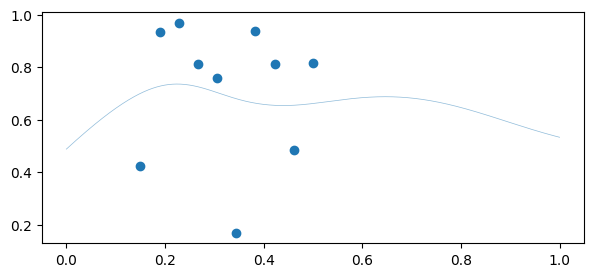

In [11]:
fig, ax = plt.subplots(figsize=(7, 3))

f_plot = tf.squeeze(model.predict_f_samples(Xnew))


# Plot some sample paths
ax.scatter(X, y)
ax.plot(Xnew, f_plot[0], alpha=0.5, linewidth=0.5, color='tab:blue')
